# Investigating The Sampling Theorem

*Copied from https://github.com/unpingco/Python-for-Signal-Processing
under Create Commons Licence [Attribution 3.0 Unported (CC BY 3.0)](https://creativecommons.org/licenses/by/3.0/deed.en_US).*

In this section, we investigate the implications of the sampling theorem. Here is the usual statement of the theorem from wikipedia:

*"If a function $x(t)$ contains no frequencies higher than B hertz, it is completely determined by giving its ordinates at a series of points spaced 1/(2B) seconds apart."*

Since a function $x(t)$ is a function from the real line to the real line, there are uncountably many points between any two ordinates, so sampling is a massive reduction of data since it only takes a tiny number of points to completely characterize the function. This is a powerful idea worth exploring. In fact, we have seen this idea of reducing a function to a discrete set of numbers before in Fourier series expansions where (for periodic $x(t)$) 

$ a_n = \frac{1}{T} \int^{T}_0 x(t) \exp (-j \omega_n t )dt $
   

with corresponding reconstruction as:

$ x(t) = \sum_k a_n \exp( j \omega_n t) $


But here we are generating discrete points $a_n$ by integrating over the **entire** function $x(t)$, not just evaluating it at a single point. This means we are collecting information about the entire function to compute a single discrete point $a_n$, whereas with sampling we are just taking individual points in isolation.

Let's come at this the other way: suppose we are given a set of samples $[x_1,x_2,..,x_N]$ and we are then told to reconstruct the function. What would we do? This is the kind of question seldom asked because we typically sample, filter, and then do something else without trying to reconstruct the function from the samples directly.

Returning to our reconstruction challenge, perhaps the most natural thing to do is draw a straight line between each of the points as in linear interpolation. The next block of code takes samples of the $sin$ over a single period and draws a line between sampled ordinates.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


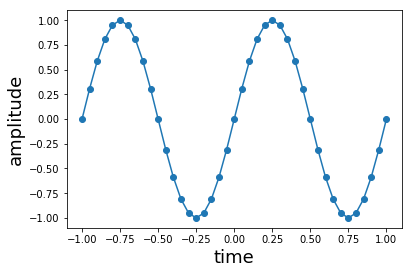

In [2]:
fig,ax = subplots()

f = 1.0  # Hz, signal frequency
fs = 20.0 # Hz, sampling rate (ie. >= 2*f) 
t = arange(-1,1+1/fs,1/fs) # sample interval, symmetric for convenience later
x = sin(2*pi*f*t)
ax.plot(t,x,'o-')
ax.set_xlabel('time',fontsize=18)
ax.set_ylabel('amplitude',fontsize=18)

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)

In this plot, notice how near the extremes of the $sin$ at $t=1/(4f)$ and $t=3/(4 f)$, we are taking the same density of points since the sampling theorem makes no requirement on *where* we should sample as long as we sample at a regular intervals. This means that on the up and down slopes of the $sin$, which are obviously linear-looking and where a linear approximation is a good one, we are taking the same density of samples as near the curvy peaks. Here's a bit of code that zooms in to the first peak to illustrate this.

(0.09999999999999998, 0.4, 0, 1.1)

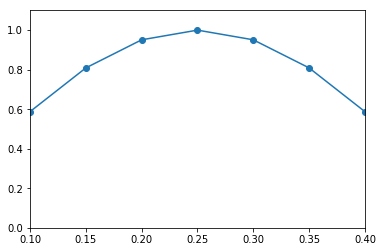

In [3]:
fig,ax = subplots()

ax.plot(t,x,'o-')
ax.axis( xmin = 1/(4*f)-1/fs*3, xmax = 1/(4*f)+1/fs*3, ymin = 0, ymax = 1.1 )
# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)

To drive this point home (and create some cool matplotlib plots), we can construct the piecewise linear interpolant and compare the quality of the approximation using ``numpy.piecewise``:

In [4]:
interval=[] # piecewise domains
apprx = []  # line on domains
# build up points *evenly* inside of intervals
tp = hstack([ linspace(t[i],t[i+1],20,False) for i in range(len(t)-1) ])
# construct arguments for piecewise2
for i in range(len(t)-1):
   interval.append( np.logical_and(t[i] <= tp,tp < t[i+1]))
   apprx.append( (x[i+1]-x[i])/(t[i+1]-t[i])*(tp[interval[-1]]-t[i]) + x[i])
x_hat = np.piecewise(tp,interval,apprx) # piecewise linear approximation

Now, we can examine the squared errors in the interpolant. The following snippet plots the $sin$ and with the filled-in error of the linear interpolant.

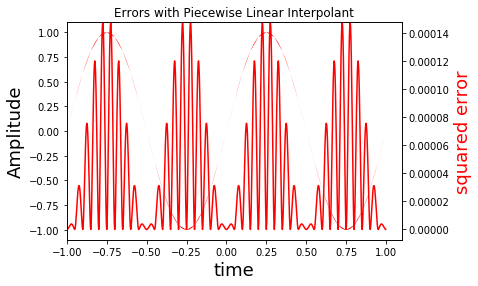

In [5]:
ax1 = figure().add_subplot(111)
ax1.fill_between(tp,x_hat,sin(2*pi*f*tp), facecolor='red')
ax1.set_xlabel('time',fontsize=18)
ax1.set_ylabel('Amplitude',fontsize=18)
ax2 = ax1.twinx()
sqe = ( x_hat - sin(2*pi*f*tp))**2
ax2.plot(tp, sqe,'r')
ax2.axis(xmin=-1,ymax= sqe.max() )
ax2.set_ylabel('squared error', color='r',fontsize=18)
ax1.set_title('Errors with Piecewise Linear Interpolant')

# ax1.figure.savefig('figure_00@.png', bbox_inches='tight', dpi=300)

Note: I urge you to change the $fs$ sampling rate in the code above then rerun this notebook to see how these errors change with more/less sampling points.

Now, we could pursue this line of reasoning with higher-order polynomials instead of just straight lines, but this would all eventually take us to the same conclusion; namely, that all of these approximations improve as the density of sample points increases, which is the *exact* opposite of what the sampling theorem says --- there is *sparse* set of samples points that will retrieve the original function. Furthermore, we observed that the quality of the piecewise linear interpolation is sensitive to *where* the sample points are taken and the sampling theorem is so powerful that it *has no such requirement*. 

## Reconstruction

Let's look at this another way by examing the Fourier Transform of a signal that is bandlimited and thus certainly satisfies the hypothesis of the sampling theorem:

$ X(f) = 0$ where $ |f|> W $

Now, the inverse Fourier transform of this is the following:
    
$ x(t) = \int_{-W}^W X(f) e^{j 2 \pi f t} df $

We can take the $X(f)$ and expand it into a Fourier series by pretending that it is periodic with period $2 W$. Thus, we can formally write the following:
    
$$ X(f) = \sum_k a_k e^{ - j 2 \pi k f/(2 W) }  $$

we can compute the coefficients $a_k$ as 

$$ a_k = \frac{1}{2 W} \int_{-W}^W X(f) e^{ j 2 \pi k f/(2 W) } df   $$

These coefficients bear a striking similarity to the $x(t)$ integral we just computed above. In fact, by lining up terms, we can write:

$$ a_k = \frac{1}{2 W} x \left(   t = \frac{k}{2 W} \right)  $$

Now, we can write out $X(f)$ in terms of this series and these $a_k$ and then invert the Fourier transform to obtain the following:

$$ x(t) = \int_{-W}^W \sum_k a_k e^{ - j 2 \pi k f/(2 W) }  e^{j 2 \pi f t} df $$

substitute for $a_k$
    
$$ x(t) = \int_{-W}^W \sum_k ( \frac{1}{2 W} x( t = \frac{k}{2 W} ) ) e^{ - j 2 \pi k f/(2 W) }  e^{j 2 \pi f t} df $$

switch summation and integration (usually dangerous, but OK here)

$$ x(t) = \sum_k x(t = \frac{k}{2 W}) \frac{1}{2 W}  \int_{-W}^W e^{ - j 2 \pi k f/(2 W) +j 2 \pi f t} df  $$

which gives finally:

$$ x(t) = \sum_k x(t = \frac{k}{2 W})  \frac{sin(\pi (k-2 t W))} {\pi (k- 2 t W)} $$

And this what we have been seeking! A formula that reconstructs the function from its samples. Let's try it!

Note that since our samples are spaced at $t= k/f_s $, we'll use $  W= f_s /2 $ to line things up.

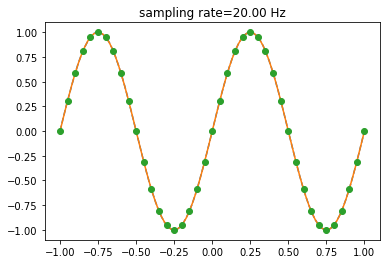

In [6]:
ax = figure().add_subplot(111)
t = linspace(-1,1,100) # redefine this here for convenience
ts = arange(-1,1+1/fs,1/fs) # sample points
num_coeffs=len(ts) 
sm=0
for k in range(-num_coeffs,num_coeffs): # since function is real, need both sides
   sm+=sin(2*pi*(k/fs))*sinc( k - fs * t)
ax.plot( t,sm,'--',t,sin(2*pi*t),ts, sin(2*pi*ts),'o')
ax.set_title('sampling rate=%3.2f Hz' % fs )

# ax.figure.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


We can do the same check as we did for the linear interpolant above as

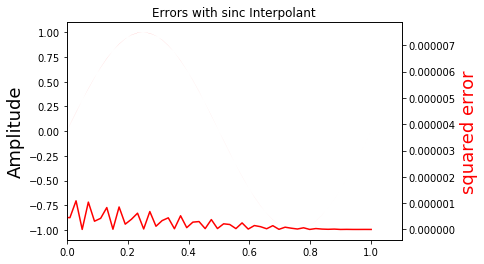

In [7]:
ax1 = figure().add_subplot(111)
ax1.fill_between(t,sm,sin(2*pi*f*t),facecolor='red')
ax1.set_ylabel('Amplitude',fontsize=18)
ax2 = ax1.twinx()
sqe = (sm - sin(2*pi*f*t))**2
ax2.plot(t, sqe,'r')
ax2.axis(xmin=0,ymax = sqe.max())
ax2.set_ylabel('squared error', color='r',fontsize=18)
ax1.set_title('Errors with sinc Interpolant')

# ax1.figure.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


These interpolating functions are called the "Whittaker" interpolating functions. Let's examine these functions more closely with the following code

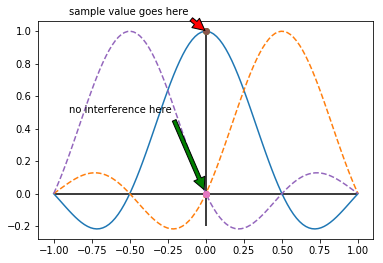

In [8]:
fig = figure()
ax = fig.add_subplot(111) # create axis handle
k=0
fs=2 # makes this plot easier to read
ax.plot (t,sinc( k - fs * t), 
         t,sinc( k+1 - fs * t),'--',k/fs,1,'o',(k)/fs,0,'o',
         t,sinc( k-1 - fs * t),'--',k/fs,1,'o',(-k)/fs,0,'o'
)
ax.hlines(0,-1,1)
ax.vlines(0,-.2,1)
ax.annotate('sample value goes here',
            xy=(0,1),
            xytext=(-1+.1,1.1),
            arrowprops={'facecolor':'red','shrink':0.05},
            )
ax.annotate('no interference here',
            xy=(0,0),
            xytext=(-1+.1,0.5),
            arrowprops={'facecolor':'green','shrink':0.05},
            )

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)

The vertical line in the previous plot shows that where one function has a peak, the other function has a zero. This is why when you put samples at each of the peaks, they match the sampled function exactly at those points. In between those points, the crown shape of the functions fills in the missing values. Furthermore, as the figure above shows, there is no interference between the functions sitting on each of the interpolating functions because the peak of one is perfectly aligned with the zero of the others (dotted lines). Thus, the sampling theorem says that the filled-in values are drawn from the curvature of the sinc functions, not straight lines as we investigated earlier. 

As an illustration, the following code shows how the individual Whittaker functions (dashed lines) are assembled into the final approximation  (black-line) using the given samples (blue-dots). I urge you to play with the sampling rate to see what happens. Note the heavy use of `numpy` broadcasting in this code instead of the multiple loops we used earlier.

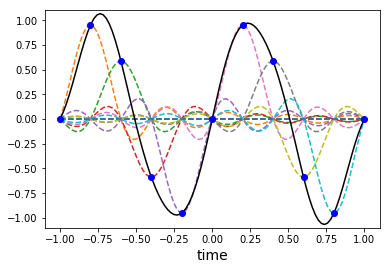

In [9]:
fs=5.0 # sampling rate
k=array(sorted(set((t*fs).astype(int)))) # sorted coefficient list
fig,ax = subplots()

ax.plot(t,(sin(2*pi*(k[:,None]/fs))*sinc(k[:,None]-fs*t)).T,'--', # individual whittaker functions
        t,(sin(2*pi*(k[:,None]/fs))*sinc(k[:,None]-fs*t)).sum(axis=0),'k-', # whittaker interpolant
     k/fs,sin(2*pi*k/fs),'ob')# samples
ax.set_xlabel('time',fontsize=14)
ax.axis((-1.1,1.1,-1.1,1.1));

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


However, if you've been following carefully, you should be somewhat uncomfortable with the second to the last plot that shows the errors in the Whittaker interpolation. Namely, *why are there any errors*? Does not the sampling theorem guarantee exact-ness which should mean no error at all? It turns out that answering this question takes us further into the implications of the sampling theorem, but that is the topic of our next post.




## Summary

In this section, we started our investigation of the famous sampling theorem that is the bedrock of the entire field of signal processing and we asked if we could reverse-engineer the consquences of the sampling theorem by reconstructing a sampled function from its discrete samples. This led us to consider the famous *Whittaker interpolator*, whose proof we sketched here. However, after all this work, we came to a disturbing conclusion regarding the exact-ness of the sampling theorem that we will investigate in a subsequent posting.  In the meantime, I urge you to start at the top of notebook and play with the sampling frequency, and maybe even the sampled function and see what else you can discover about the sampling theorem.

## References


* This is in the [IPython Notebook format](http://ipython.org/) and was converted to HTML using [nbconvert](https://github.com/ipython/nbconvert).

* See [Signal analysis](http://books.google.com/books?id=Re5SAAAAMAAJ) for more detailed mathematical development.

* The IPython Notebook corresponding to this post can be found [here](https://github.com/unpingco/Python-for-Signal-Processing/blob/master/Sampling_Theorem.ipynb).